In [34]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [3]:
list_test = [0.013588268535108528j, -0.012763515663970715j, 0.012070076757241921j, -0.011805638151917819j, 0.011039307342297633j, -0.010086123938489067j, 
0.00873873251259738j, -0.006891155203387456j, 0.004886613986961663j]

In [5]:
np.array(list_test)/np.pi

array([ 0.+0.00432528j, -0.-0.00406275j,  0.+0.00384202j, -0.-0.00375785j,
        0.+0.00351392j, -0.-0.00321051j,  0.+0.00278162j, -0.-0.00219352j,
        0.+0.00155546j])

In [2]:
h = 0.2
deg = 5

In [3]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [14]:
center1 = (1.75, 0, 0)
center2 = (-1.75, 0, 0)

sphere1 = bempp.api.shapes.sphere(r = 0.25, h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(r = 0.25, h=h, origin=center2)
combined_scatters = bempp.api.grid.grid.union([sphere1,sphere2])

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)
space_combined = bempp.api.function_space(combined_scatters,'P',1)

unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

In [15]:
mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [16]:
sph_harm_coeff = []

for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def sph_harm(x,n,domain_index,result):
            with objmode():
                result[0] = normalized_spherical_harmonics(p,q,x)
        sph_harm_grid = bempp.api.GridFunction(space_unit_sphere, fun = sph_harm)
        sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

In [17]:
N = 20
lbound = 0.0005
ubound = 30
results = np.empty(N, dtype='float64')

In [51]:
for index, point in enumerate(np.linspace(lbound, ubound, N)):
    wavenumber = point
    eta = wavenumber

    identity1 = bempp.api.operators.boundary.sparse.identity(space_sphere1, space_sphere1, space_sphere1)
    slp1 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    dlp1 = bempp.api.operators.boundary.helmholtz.double_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp_far1 = helmholtz_farfield.single_layer(space_sphere1, vert_unit_sphere, wavenumber)
    dlp_far1 = helmholtz_farfield.double_layer(space_sphere1, vert_unit_sphere, wavenumber)

    lhs1 = 0.5 * identity1 + dlp1 - 1j* eta *slp1

    identity2 = bempp.api.operators.boundary.sparse.identity(space_sphere2, space_sphere2, space_sphere2)
    slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2, space_sphere2, space_sphere2, wavenumber)
    dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_sphere2, space_sphere2, space_sphere2, wavenumber)
    slp_far2 = helmholtz_farfield.single_layer(space_sphere2, vert_unit_sphere, wavenumber)
    dlp_far2 = helmholtz_farfield.double_layer(space_sphere2, vert_unit_sphere, wavenumber)

    lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

    identity = bempp.api.operators.boundary.sparse.identity(space_combined, space_combined, space_combined)
    slp = bempp.api.operators.boundary.helmholtz.single_layer(space_combined, space_combined, space_combined, wavenumber)
    dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_combined, space_combined, space_combined, wavenumber)
    slp_far = helmholtz_farfield.single_layer(space_combined, vert_unit_sphere, wavenumber)
    dlp_far = helmholtz_farfield.double_layer(space_combined, vert_unit_sphere, wavenumber)

    lhs = 0.5 * identity + dlp - 1j* eta *slp
    
    #===================================================================================================================
    slp_far_field_coeff1 = []
    slp_far_field_coeff2 = []
    slp_far_field_coeff = []

    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun1 = bempp.api.GridFunction(space_sphere1, fun = dirichlet_fun)
            field1, info1 = bempp.api.linalg.gmres(lhs1, rhs_fun1, tol=1E-8)
            slp_far_field_coeff1.append(dlp_far1.evaluate(field1) - 1j * eta * slp_far1.evaluate(field1))

            rhs_fun2 = bempp.api.GridFunction(space_sphere2, fun = dirichlet_fun)
            field2, info2 = bempp.api.linalg.gmres(lhs2, rhs_fun2, tol=1E-8)
            slp_far_field_coeff2.append(dlp_far2.evaluate(field2) - 1j * eta * slp_far2.evaluate(field2))

            rhs_fun = bempp.api.GridFunction(space_combined, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-8)
            slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))
            
    #====================================================================================================
    T_matrix1 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix1[i,j] = (slp_far_field_coeff1[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    T_matrix2 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix2[i,j] = (slp_far_field_coeff2[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    S_matrix = np.identity(T_matrix.shape[0]) + 2*T_matrix
    S_matrix1 = np.identity(T_matrix1.shape[0]) + 2*T_matrix1
    S_matrix2 = np.identity(T_matrix2.shape[0]) + 2*T_matrix2

    rhs_value_S =  (np.log(np.linalg.det(S_matrix))-(np.log(np.linalg.det(S_matrix1)) + np.log(np.linalg.det(S_matrix2))))/(2*np.pi*1j)
    print(wavenumber, rhs_value_S)

0.0005 (4.116011286560776e-06-9.480473531887071e-07j)
1.579421052631579 (-0.000722183275979323+1.2635076341036735e-05j)
3.1583421052631584 (1.001941829789689-0.0016953713467006937j)
4.737263157894737 (-0.014218651047148553-0.014755336438349604j)
6.316184210526316 (-0.011765093913188205-0.004047862284239621j)
7.8951052631578955 (-0.011201382102671121-0.004668266180561178j)
9.474026315789475 (-0.013745877117262537+0.002680153521865585j)
11.052947368421055 (-0.008817850025999076+0.008359908818746521j)
12.631868421052634 (-0.005978243598380793+0.008664323991161248j)
14.210789473684212 (-0.005505563091027958+0.009246946646802813j)
15.789710526315792 (-0.004653007158082672+0.014017987321476771j)
17.36863157894737 (0.004527508570255657+0.00773187105280984j)
18.947552631578947 (0.002282496450994879+0.005825219764396032j)
20.526473684210526 (0.0077415235644712555+0.0035336406058598642j)
22.105394736842108 (0.0038467161068288123+0.004545774093326351j)
23.684315789473686 (0.004356447677552122+0.0

In [62]:
k = points[-4]

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, k)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, k)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , k)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , k)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

p,l,u = scipy.linalg.lu(mat)
logdet_mat = 0
for i in range(u.shape[0]):
    logdet_mat += cmath.log(u[i,i])

p2,l2,u2 = scipy.linalg.lu(mat2)
logdet_mat2 = 0
for i in range(u2.shape[0]):
    logdet_mat2 += cmath.log(u2[i,i])

logdet = logdet_mat - logdet_mat2

print(np.imag(logdet/np.pi))

0.0025453251459168105


In [21]:
points = np.linspace(lbound, ubound, N)

In [40]:
result_10 = np.array([4.116011286560776e-06 * np.exp(-10*points[0]**2),
 -0.000722183275979323 * np.exp(-10*points[1]**2),
 1.001941829789689 * np.exp(-10*points[2]**2),
 -0.014218651047148553 * np.exp(-10*points[3]**2),
 -0.011765093913188205 * np.exp(-10*points[4]**2),
 -0.011201382102671121 * np.exp(-10*points[5]**2),
 -0.013745877117262537 * np.exp(-10*points[6]**2),
 -0.008817850025999076 * np.exp(-10*points[7]**2),
 -0.005978243598380793 * np.exp(-10*points[8]**2),
 -0.005505563091027958 * np.exp(-10*points[9]**2),
 -0.004653007158082672 * np.exp(-10*points[10]**2),
 0.004527508570255657 * np.exp(-10*points[11]**2),
 0.002282496450994879 * np.exp(-10*points[12]**2),
 0.0077415235644712555 * np.exp(-10*points[13]**2),
 0.0038467161068288123 * np.exp(-10*points[14]**2),
 0.004356447677552122 * np.exp(-10*points[15]**2),
 0.003827460532150172 * np.exp(-10*points[16]**2),
 0.003586504996897478 * np.exp(-10*points[17]**2),
 0.002267885143652168 * np.exp(-10*points[18]**2),
 0.0018409878453814494 * np.exp(-10*points[19]**2)])

In [47]:
casimir_energy_10 = np.trapz(result_10, points) * np.pi
print(casimir_energy_10)

1.020835493137441e-05


In [43]:
result_5 = np.array([4.116011286560776e-06 * np.exp(-5*points[0]**2),
 -0.000722183275979323 * np.exp(-5*points[1]**2),
 1.001941829789689 * np.exp(-5*points[2]**2),
 -0.014218651047148553 * np.exp(-5*points[3]**2),
 -0.011765093913188205 * np.exp(-5*points[4]**2),
 -0.011201382102671121 * np.exp(-5*points[5]**2),
 -0.013745877117262537 * np.exp(-5*points[6]**2),
 -0.008817850025999076 * np.exp(-5*points[7]**2),
 -0.005978243598380793 * np.exp(-5*points[8]**2),
 -0.005505563091027958 * np.exp(-5*points[9]**2),
 -0.004653007158082672 * np.exp(-5*points[10]**2),
 0.004527508570255657 * np.exp(-5*points[11]**2),
 0.002282496450994879 * np.exp(-5*points[12]**2),
 0.0077415235644712555 * np.exp(-5*points[13]**2),
 0.0038467161068288123 * np.exp(-5*points[14]**2),
 0.004356447677552122 * np.exp(-5*points[15]**2),
 0.003827460532150172 * np.exp(-5*points[16]**2),
 0.003586504996897478 * np.exp(-5*points[17]**2),
 0.002267885143652168 * np.exp(-5*points[18]**2),
 0.0018409878453814494 * np.exp(-5*points[19]**2)])

In [48]:
casimir_energy_5 = np.trapz(result_5, points) * np.pi
print(casimir_energy_5)

1.0194650530295636e-05


In [45]:
result_1 = np.array([4.116011286560776e-06 * np.exp(-points[0]**2),
 -0.000722183275979323 * np.exp(-points[1]**2),
 1.001941829789689 * np.exp(-points[2]**2),
 -0.014218651047148553 * np.exp(-points[3]**2),
 -0.011765093913188205 * np.exp(-points[4]**2),
 -0.011201382102671121 * np.exp(-points[5]**2),
 -0.013745877117262537 * np.exp(-points[6]**2),
 -0.008817850025999076 * np.exp(-points[7]**2),
 -0.005978243598380793 * np.exp(-points[8]**2),
 -0.005505563091027958 * np.exp(-points[9]**2),
 -0.004653007158082672 * np.exp(-points[10]**2),
 0.004527508570255657 * np.exp(-points[11]**2),
 0.002282496450994879 * np.exp(-points[12]**2),
 0.0077415235644712555 * np.exp(-points[13]**2),
 0.0038467161068288123 * np.exp(-points[14]**2),
 0.004356447677552122 * np.exp(-points[15]**2),
 0.003827460532150172 * np.exp(-points[16]**2),
 0.003586504996897478 * np.exp(-points[17]**2),
 0.002267885143652168 * np.exp(-points[18]**2),
 0.0018409878453814494 * np.exp(-points[19]**2)])

In [49]:
casimir_energy_1 = np.trapz(result_1, points) * np.pi
print(casimir_energy_1)

-5.412373800921117e-05


In [36]:
result_05 = np.array([4.116011286560776e-06 * np.exp(-0.5*points[0]**2),
 -0.000722183275979323 * np.exp(-0.5*points[1]**2),
 1.001941829789689 * np.exp(-0.5*points[2]**2),
 -0.014218651047148553 * np.exp(-0.5*points[3]**2),
 -0.011765093913188205 * np.exp(-0.5*points[4]**2),
 -0.011201382102671121 * np.exp(-0.5*points[5]**2),
 -0.013745877117262537 * np.exp(-0.5*points[6]**2),
 -0.008817850025999076 * np.exp(-0.5*points[7]**2),
 -0.005978243598380793 * np.exp(-0.5*points[8]**2),
 -0.005505563091027958 * np.exp(-0.5*points[9]**2),
 -0.004653007158082672 * np.exp(-0.5*points[10]**2),
 0.004527508570255657 * np.exp(-0.5*points[11]**2),
 0.002282496450994879 * np.exp(-0.5*points[12]**2),
 0.0077415235644712555 * np.exp(-0.5*points[13]**2),
 0.0038467161068288123 * np.exp(-0.5*points[14]**2),
 0.004356447677552122 * np.exp(-0.5*points[15]**2),
 0.003827460532150172 * np.exp(-0.5*points[16]**2),
 0.003586504996897478 * np.exp(-0.5*points[17]**2),
 0.002267885143652168 * np.exp(-0.5*points[18]**2),
 0.0018409878453814494 * np.exp(-0.5*points[19]**2)])

In [50]:
casimir_energy_05 = np.trapz(result_05, points) * np.pi
print(casimir_energy_05)

0.03288655921519942


In [38]:
result_025 = np.array([4.116011286560776e-06 * np.exp(-0.25*points[0]**2),
 -0.000722183275979323 * np.exp(-0.25*points[1]**2),
 1.001941829789689 * np.exp(-0.25*points[2]**2),
 -0.014218651047148553 * np.exp(-0.25*points[3]**2),
 -0.011765093913188205 * np.exp(-0.25*points[4]**2),
 -0.011201382102671121 * np.exp(-0.25*points[5]**2),
 -0.013745877117262537 * np.exp(-0.25*points[6]**2),
 -0.008817850025999076 * np.exp(-0.25*points[7]**2),
 -0.005978243598380793 * np.exp(-0.25*points[8]**2),
 -0.005505563091027958 * np.exp(-0.25*points[9]**2),
 -0.004653007158082672 * np.exp(-0.25*points[10]**2),
 0.004527508570255657 * np.exp(-0.25*points[11]**2),
 0.002282496450994879 * np.exp(-0.25*points[12]**2),
 0.0077415235644712555 * np.exp(-0.25*points[13]**2),
 0.0038467161068288123 * np.exp(-0.25*points[14]**2),
 0.004356447677552122 * np.exp(-0.25*points[15]**2),
 0.003827460532150172 * np.exp(-0.25*points[16]**2),
 0.003586504996897478 * np.exp(-0.25*points[17]**2),
 0.002267885143652168 * np.exp(-0.25*points[18]**2),
 0.0018409878453814494 * np.exp(-0.25*points[19]**2)])

In [39]:
casimir_energy_025 = np.trapz(abs(result_025), points) * np.pi
print(casimir_energy_025)

0.41269507976673847


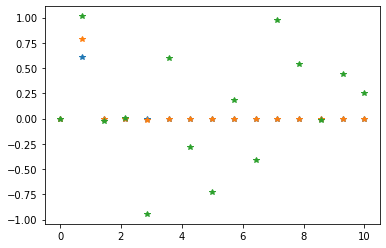

In [29]:
plt.plot(points, results_1, '*')
plt.plot(points, results_05, '*')
plt.plot(points, results_025, '*')

In [33]:
casimir_energy = np.trapz(results_025, points) *0.5
print(f"The normalized Casimir Energy is: {casimir_energy}")

The normalized Casimir Energy is: 0.5406819181332221


In [10]:
np.linspace(lbound, ubound, N)

array([5.00000e-04, 7.14750e-01, 1.42900e+00, 2.14325e+00, 2.85750e+00,
       3.57175e+00, 4.28600e+00, 5.00025e+00, 5.71450e+00, 6.42875e+00,
       7.14300e+00, 7.85725e+00, 8.57150e+00, 9.28575e+00, 1.00000e+01])